In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import keras

print("Keras version:", keras.__version__)

Keras version: 3.10.0


In [3]:
IMAGE_SIZE = 96
IMAGE_CHANNEL = 3
BATCH_SIZE = 32
SAMPLE_SIZE = 5_000

In [4]:
from typing import Literal

def get_running_environment() -> Literal['local', 'colab', 'kaggle', 'marimo', 'jupyter']:
    """
    Returns the current running environment.
    """
    if 'COLAB_GPU' in os.environ:
        return 'colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'kaggle'
    elif 'MARIMO' in os.environ:
        return 'marimo'
    elif 'JUPYTERHUB_USER' in os.environ:
        return 'jupyter'
    else:
        return 'local'
current_env = get_running_environment()

def get_data_path(running_env: str) -> str:
    """
    Returns the path to the data directory based on the running environment.
    """
    if running_env == 'colab':
        return '/content/data'
    elif running_env == 'kaggle':
        return '/kaggle/input/histopathologic-cancer-detection'
    elif running_env == 'marimo':
        return '/data'
    else:
        # return './data/histopathologic-cancer-detection'
        return './data'
    
def set_random_seed(seed: int = 42):
    """
    Sets the random seed for reproducibility.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"Random seed set to {seed}")

data_dir = get_data_path(current_env)
print(f"Data path: {data_dir} (for {current_env} environment)")

RANDOM_SEED = 42

set_random_seed(RANDOM_SEED)

Data path: ./data (for local environment)
Random seed set to 42


In [5]:
df_full = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))


if SAMPLE_SIZE > 0:
    print(f"SAMPLE_SIZE is set to {SAMPLE_SIZE}. Sampling the dataset...")

    total_0 = df_full[df_full['label'] == 0].value_counts('label').values[0]
    total_1 = df_full[df_full['label'] == 1].value_counts('label').values[0]

    ratio = total_1 / total_0
    print(f"Total samples with label 0: {total_0}, label 1: {total_1}, ratio: {ratio}")

    target_1 = int(SAMPLE_SIZE * ratio / (1 + ratio))
    target_0 = SAMPLE_SIZE - target_1
    print(f"Target samples with label 0: {target_0}, label 1: {target_1}")

    df_0 = df_full[df_full['label'] == 0].sample(target_0, random_state=RANDOM_SEED)
    df_1 = df_full[df_full['label'] == 1].sample(target_1, random_state=RANDOM_SEED)

    df = pd.concat([df_0, df_1]).reset_index(drop=True)
else:
    print(f"SAMPLE_SIZE has not been set. Using full dataset with {len(df_full)} samples.")
    df = df_full.copy()
df

SAMPLE_SIZE is set to 5000. Sampling the dataset...
Total samples with label 0: 130908, label 1: 89117, ratio: 0.680760534115562
Target samples with label 0: 2975, label 1: 2025


,id,label
0,941ffe73059292e0effd4e81ca9363c117afc2f4,0
1,43b6acadb31161c9281460efa3fad0b992a92837,0
2,64cfb56ddf41e2a871ac5164d61e50b238b9ed1b,0
3,9464cf403653088420cdb78acacd8cf7fa2255e4,0
4,346bc5b2d383d70dfccb8fe9102c7f55687f5f52,0
...,...,...
4995,594c38a44003360fc871c3dda7d9c9e41d02c37c,1
4996,00da9cfbdc1b02f7919689bf250b4f4ac752d0eb,1
4997,3937e1708dabeb36f843b90ecfcb1c826d0d920e,1
4998,ebe88872966f27df3f4b36060bd5da59e0105b6a,1


In [6]:
df.value_counts('label')

label
0    2975
1    2025
Name: count, dtype: int64

In [7]:
from prepare_dataset import DataPreprocessor
data_processor = DataPreprocessor(data_dir=data_dir, dataset=df, output_dir='./data/sample')

In [8]:
train_processed_dir = data_processor.run('train', forced=True)
print(f"Processed train directory: {train_processed_dir}")

test_processed_dir = data_processor.run('test', forced=True)
print(f"Processed test directory: {test_processed_dir}")

processed directory exists
Removing the current directory
creating directories for processed images


Converting images: 100%|██████████| 5000/5000 [00:01<00:00, 3340.18it/s]


Processed train directory: ./data/sample/train_processed
processed directory exists
Removing the current directory
creating directories for processed images


Converting images: 100%|██████████| 57458/57458 [00:08<00:00, 6505.77it/s]

Processed test directory: ./data/sample/test_processed


In [9]:
VALIDATION_SPLIT = 0.2

train_ds = image_dataset_from_directory(
    train_processed_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=RANDOM_SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'  # Binary labels (0 or 1)
)


Found 5000 files belonging to 2 classes.
Using 4000 files for training.


2025-07-28 22:21:10.641584: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-28 22:21:10.641620: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-28 22:21:10.641637: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753734070.641657  505385 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753734070.641699  505385 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
val_ds = image_dataset_from_directory(
    train_processed_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

Found 5000 files belonging to 2 classes.
Using 1000 files for validation.


In [11]:
test_ds = image_dataset_from_directory(
    test_processed_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=None,  # No labels for test
    shuffle=False  # Preserve order for submission
)

Found 57458 files.


2025-07-28 22:21:12.773719: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


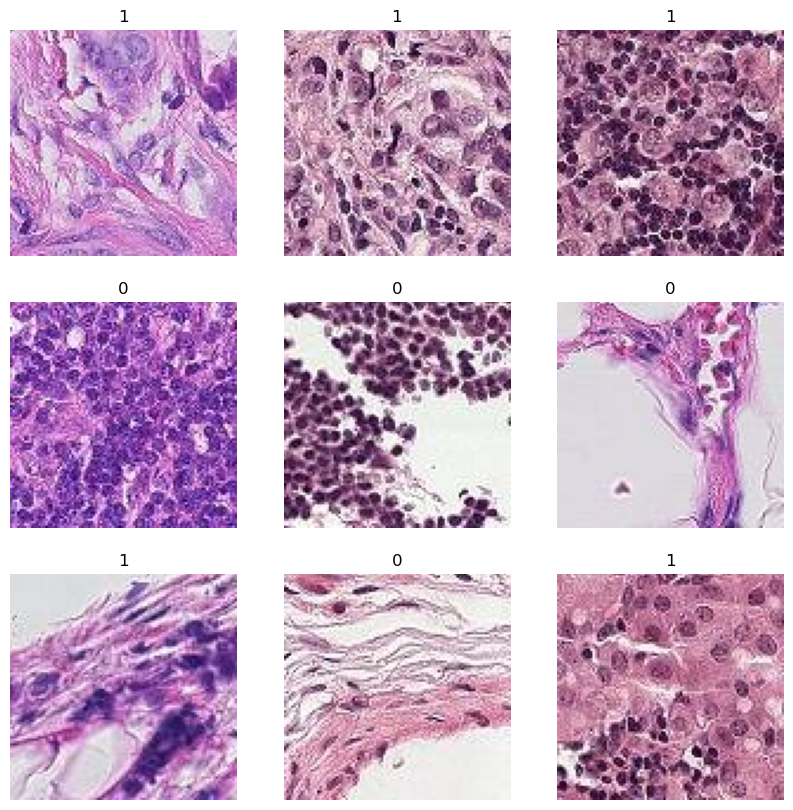

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])


2025-07-28 22:21:13.584701: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


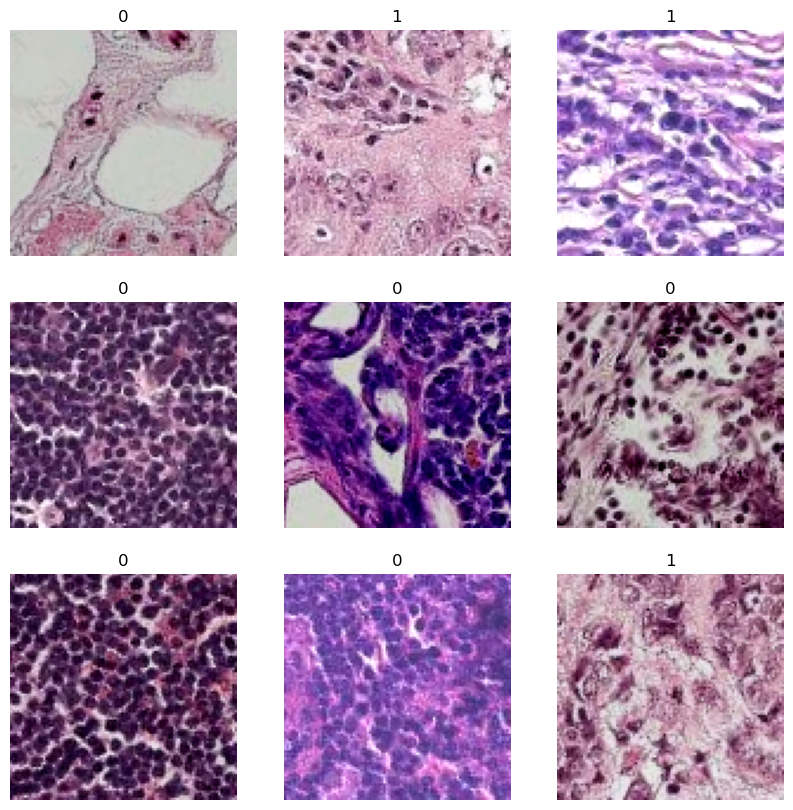

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images[i:i+1])
        plt.imshow(np.array(augmented_image[0]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
# apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [16]:
def build_simple_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)) -> keras.Model:
    """
    Builds a simple CNN model.
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [17]:
simple_cnn = build_simple_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL))

In [18]:
simple_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
simple_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        70,689 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,585 (279.63 KB)

 Trainable params: 71,585 (279.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from sklearn.utils.class_weight import compute_class_weight
def get_class_weights(dataset: pd.DataFrame) -> dict:
    """
    Computes class weights for the dataset.
    """
    labels = dataset['label'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    return class_weight_dict


In [20]:
from datetime import datetime


def predict_and_save_submission(
    keras_model: keras.Model, model_name: str, test_dataset: tf.data.Dataset, output_dir: str
) -> tuple:
    # Predict
    test_ids = [f[:-4] for f in os.listdir(test_processed_dir) if f.endswith(".jpg")]
    predictions = keras_model.predict(test_dataset).flatten()
    submission = pd.DataFrame(
        {"id": test_ids, "label": (predictions > 0.5).astype(int)}
    )

    # Save submission with date and time in the filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    submission_filename = f"submission_{model_name}_{timestamp}.csv"
    print(f"Saving submission to {submission_filename}")

    submission_path = os.path.join(output_dir, submission_filename)

    submission.to_csv(submission_path, index=False)
    return (predictions, submission_path)

In [21]:
# fit 
simple_cnn_history = simple_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=get_class_weights(df),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("checkpoints/simple_cnn/save_at_{epoch}.keras"),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/10


2025-07-28 22:21:14.114761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5449 - loss: 93.6363 - val_accuracy: 0.5810 - val_loss: 1.1280
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5765 - loss: 1.0283 - val_accuracy: 0.5260 - val_loss: 1.1060
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5421 - loss: 0.9675 - val_accuracy: 0.5300 - val_loss: 0.8819
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5375 - loss: 0.8346 - val_accuracy: 0.5280 - val_loss: 0.8135
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5320 - loss: 0.8004 - val_accuracy: 0.5270 - val_loss: 0.8020
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5282 - loss: 0.7915 - val_accuracy: 0.5050 - val_loss: 0.7604
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5161 - loss: 0.7735 - val_accuracy: 0.5320 - val_loss: 0.7387
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5096 - loss: 0.7377 - val_accuracy: 0.53

In [22]:
# predict on the test dataset
predictions, _ = predict_and_save_submission(simple_cnn,  "simple_cnn", test_ds, output_dir='./submissions')
predictions = (predictions > 0.5).astype(int)  # Convert probabilities
predictions = predictions.flatten()  # Flatten to 1D array

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
Saving submission to submission_simple_cnn_20250728_222151.csv


In [23]:
# precent of predictions by label
percent_0 = np.mean(predictions == 0) * 100
percent_1 = np.mean(predictions == 1) * 100
print(f"Predictions: {percent_0:.2f}% label 0, {percent_1:.2f}% label 1")
print(f"Total predictions: {len(predictions)}, label 0: {np.sum(predictions == 0)}, label 1: {np.sum(predictions == 1)}")

Predictions: 44.41% label 0, 55.59% label 1
Total predictions: 57458, label 0: 25515, label 1: 31943


In [24]:
predict_and_save_submission(simple_cnn, "simple_cnn", test_ds, output_dir='./submissions')

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
Saving submission to submission_simple_cnn_20250728_222202.csv


(array([0.5105918 , 0.63011056, 0.30687636, ..., 0.5601297 , 0.55328196,
        0.00265187], shape=(57458,), dtype=float32),
 './submissions/submission_simple_cnn_20250728_222202.csv')

<Axes: >

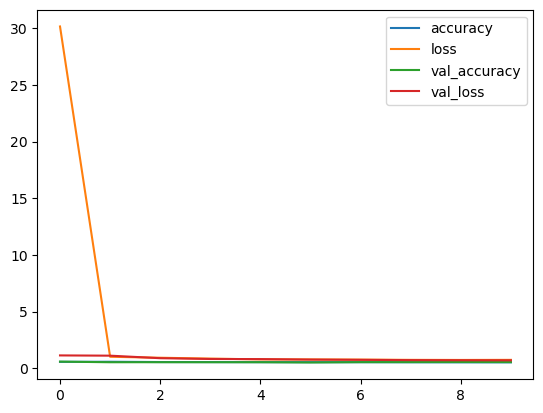

In [25]:
# pd.DataFrame(simple_cnn.history).plot()
pd.DataFrame(simple_cnn_history.history).plot()